# GDELT Example & Tutorial
#### Disclaimer: Using a notebook for the data collection is not the best solution, one should make a separate script and a a batch script or similar to query long periods.

This notebook gives a brief example on how to query GDELT for JSON data and how to filter it. For better explanation on the available fields etc. see the Codebook and other GDELT documentation. 

For scraping the original text data, one needs to use requests, BeatifulSoup or similar library to get the HTML, after which one can turn it into markdown or other readable form with html2text.

Good links:
1. https://pypi.org/project/gdelt/
2. https://nbviewer.jupyter.org/github/JamesPHoughton/Published_Blog_Scripts/blob/master/GDELT%20Wrangler%20-%20Clean.ipynb
3. https://github.com/linwoodc3/gdeltPyR
4. https://towardsdatascience.com/making-sense-of-the-news-part-1-introduction-f171d1da65a8


In [1]:
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from collections import Counter
import requests
import re
import gdelt
import glob
plt.style.use('ggplot')
import datetime as dt
import operator
import gc
from calendar import monthrange

In [4]:
def query_day(gd2, date, theme, location):
    results = gd2.Search(date,table='gkg',output='json', coverage=True, translation=False)
    mapper = []
    res = json.loads(results)
    for news in res:
        #Filter by theme and location, adjust as you please
        if news['V2Themes'] and news['V2Locations']:
            if theme in news['V2Themes'] and location in news['V2Locations']:
                mapper.append(news)

    #Free some mem
    res = ''
    results = ''
    return mapper

def get_gdelt(month, year, filepath, theme, location):
    '''
    Example:
    get_gdelt(12,2019, '/l/GDELT/', 'ECON','Boston') for Dec. 2019 economy related news mentioning Boston
    
    The filters can be removed (for getting all the news) or adjusted as you please.
    
    '''
    gc.enable()
    # Version 2 queries
    gd2 = gdelt.gdelt(version=2)
    newscount = 0
    dd = monthrange(int(year), int(month))[1]
    dd=3
    for day in tqdm(range(1,dd+1)):
        date = str(year)+' '+fixstr(month)+' '+fixstr(day)
        newsset = []
        for f in range(10):
            try:
                newsset = query_day(gd2, date, theme, location)
                break
            except: print(f, 'th retry on: ', date)
        with open(filepath+date.replace(' ','_')+'_data.json', 'w') as fp:
            #Save the JSON
            json.dump(newsset, fp)
        newscount+=len(newsset)
        #newsset=[]
        gc.collect()
    print('GDELT returned ', newscount,'articles for the month.')

def fixstr(daymonth):
    #Fix the 0s
    if daymonth<10:
        return '0'+str(daymonth)
    else: return str(daymonth)

In [ ]:
filepath = 'YOURPATH'
get_gdelt(12,2019,filepath,'ECON', 'Boston')

In [ ]:
volume = []

for f in tqdm(glob.glob(filepath+'*.json')):
    fnam = f.split('/')[-1]
    vol = 0
    fil = []
    with open(f, "r") as read_file:
        data = json.load(read_file)
    for news in data:
        if news['V2Locations'] != None and news['V2Themes']:
            if 'ECON' in news['V2Themes'] and 'Boston' in news['V2Locations']:
                print(vol)
                vol+=1
                fil.append(news)
    volume.append(vol)
    with open(filepath+fnam, "w") as save_file:
        json.dump(fil,save_file)

In [ ]:
'''
Plotting the sentiment avg, mins and maxs and making a subset.
'''

sentiment = []
senmin = []
senmax = []
finset = []
for f in tqdm(glob.glob(filepath+'*.json')):
    sent_tmp = []
    with open(f, "r") as read_file:
        data = json.load(read_file)
    for news in data:
        if news['V2Tone'] != None:
            sent_tmp.append(float(news['V2Tone'].split(',')[0]))
            if news['V2Themes'] != None:
                if 'ECON' in news['V2Themes'] or 'BANK' in news['V2Themes']:
                    finset.append(news)
    senmax.append(np.max(sent_tmp))
    senmin.append(np.min(sent_tmp))
    sentiment.append(np.average(sent_tmp))

Text(0.5, 1.0, 'Tone in Cleveland Economy related news Aug - Oct')

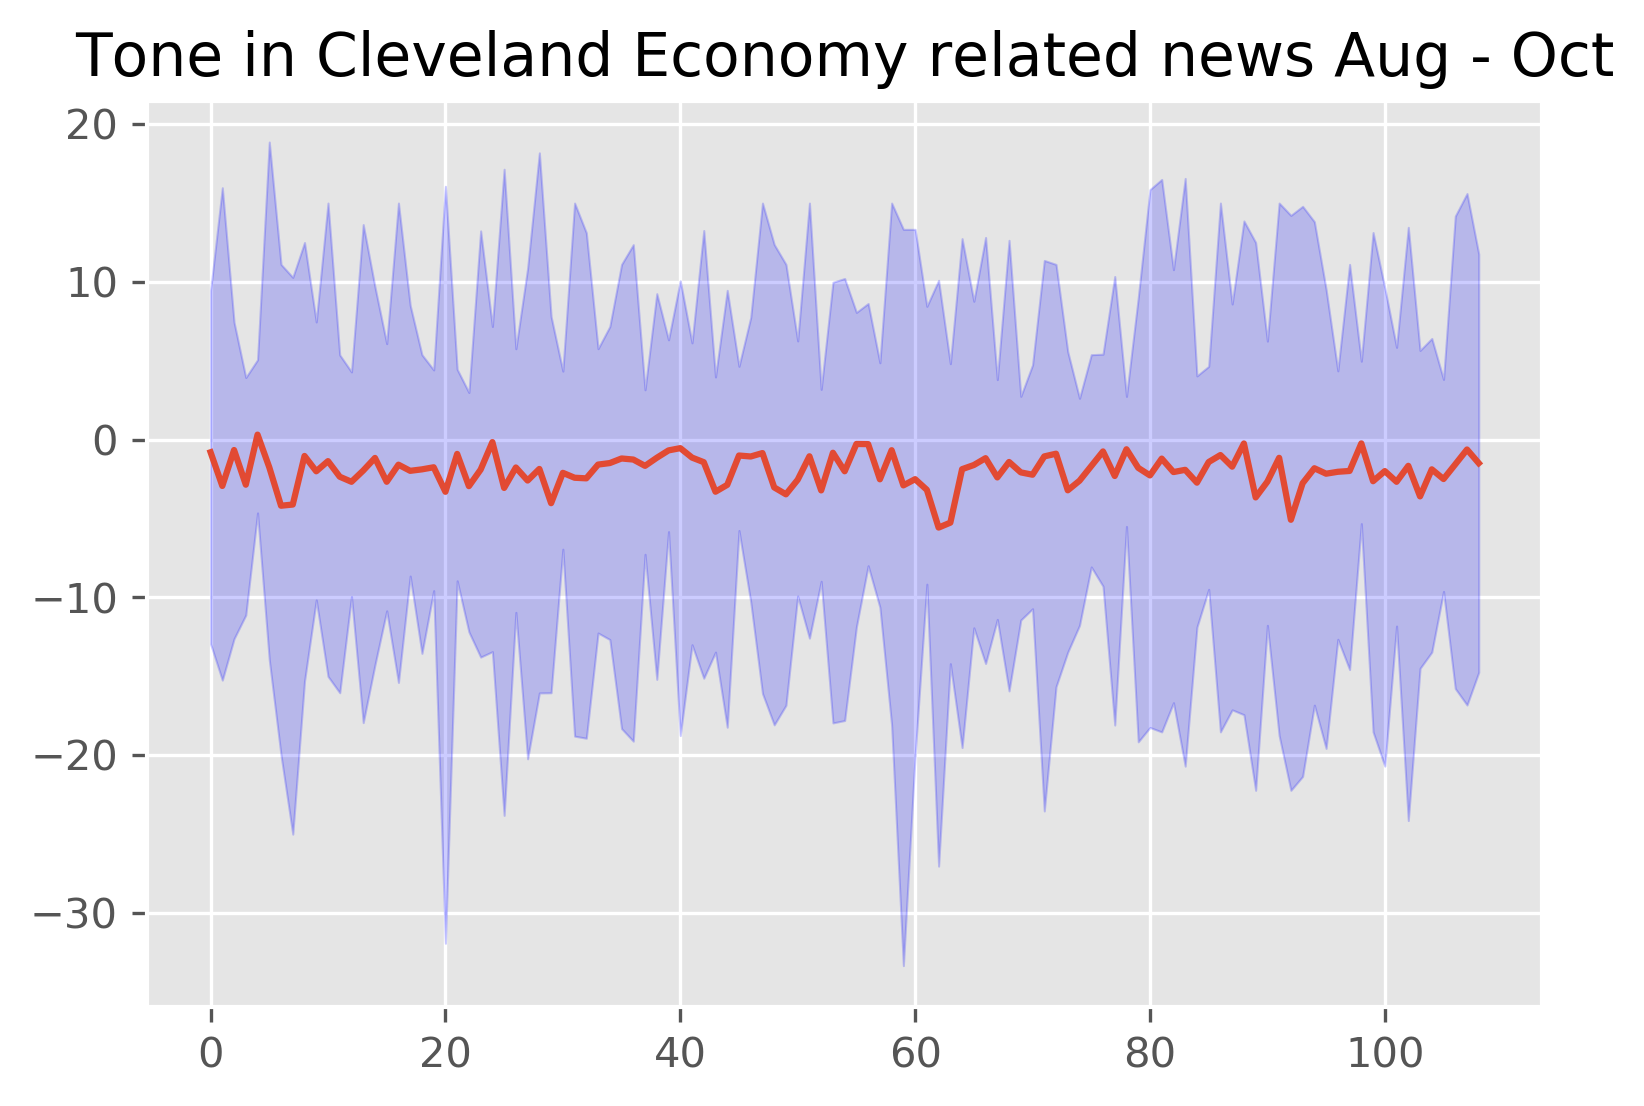

In [13]:
plt.figure(figsize=(6, 4), dpi=300, facecolor='w', edgecolor='k')
plt.plot(np.arange(len(sentiment)), sentiment)
plt.fill_between(np.arange(len(sentiment)), senmin,senmax, alpha=0.2, color='blue')
plt.title('Tone in Cleveland Economy related news Aug - Oct')


In [ ]:
filename = 'filtered.json'
with open(filepath+filename, "w") as save_file:
        json.dump(finset,save_file)